In [1]:
# importing libs
import numpy as np
%matplotlib inline 
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K

Using TensorFlow backend.


In [2]:
# for reproducing reslut
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(3)

In [3]:
# defining parameters
# define (n,k) here for (n,k) autoencoder
# n = n_channel 
# k = log2(M)  ==> so for (7,4) autoencoder n_channel = 7 and M = 2^4 = 16 
M = 4
k = np.log2(M)
k = int(k)
n_channel = 2
R = k/n_channel
print ('M:',M,'k:',k,'n:',n_channel)

M: 4 k: 2 n: 2


In [4]:
#generating data of size N
N = 8000
label = np.random.randint(M,size=N)

In [5]:
# creating one hot encoded vectors
data = []
for i in label:
    temp = np.zeros(M)
    temp[i] = 1
    data.append(temp)

In [6]:
# checking data shape
data = np.array(data)
print (data.shape)

(8000, 4)


In [7]:
# checking generated data with it's label
temp_check = [17,23,45,67,89,96,72,250,350]
for i in temp_check:
    print(label[i],data[i])

1 [0. 1. 0. 0.]
0 [1. 0. 0. 0.]
1 [0. 1. 0. 0.]
3 [0. 0. 0. 1.]
1 [0. 1. 0. 0.]
3 [0. 0. 0. 1.]
0 [1. 0. 0. 0.]
3 [0. 0. 0. 1.]
0 [1. 0. 0. 0.]


In [8]:
# defining autoencoder and it's layer
input_signal = Input(shape=(M,))
encoded = Dense(M, activation='relu')(input_signal)
encoded1 = Dense(n_channel, activation='linear')(encoded)
encoded2 = Lambda(lambda x: np.sqrt(n_channel)*K.l2_normalize(x,axis=1))(encoded1)

EbNo_train = 5.01187 #  coverted 7 db of EbNo
encoded3 = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(encoded2)

decoded = Dense(M, activation='relu')(encoded3)
decoded1 = Dense(M, activation='softmax')(decoded)
autoencoder = Model(input_signal, decoded1)
adam = Adam(lr=0.01)
autoencoder.compile(optimizer=adam, loss='categorical_crossentropy')

In [9]:
# printing summary of layers and it's trainable parameters 
print (autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
lambda_1 (Lambda)            (None, 2)                 0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
Total para

In [ ]:
# for tensor board visualization
#tbCallBack = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

In [10]:
# traning auto encoder
autoencoder.fit(data, data,
                epochs=45,
                batch_size=32)

Epoch 1/45
8000/8000 [==============================] - 1s 80us/step - loss: 0.4002
Epoch 2/45
8000/8000 [==============================] - 0s 34us/step - loss: 0.0164
Epoch 3/45
8000/8000 [==============================] - 0s 34us/step - loss: 0.0110
Epoch 4/45
8000/8000 [==============================] - 0s 35us/step - loss: 0.0104
Epoch 5/45
8000/8000 [==============================] - 0s 35us/step - loss: 0.0069
Epoch 6/45
8000/8000 [==============================] - 0s 36us/step - loss: 0.0087
Epoch 7/45
8000/8000 [==============================] - 0s 34us/step - loss: 0.0057
Epoch 8/45
8000/8000 [==============================] - 0s 36us/step - loss: 0.0086
Epoch 9/45
8000/8000 [==============================] - 0s 33us/step - loss: 0.0086
Epoch 10/45
8000/8000 [==============================] - 0s 32us/step - loss: 0.0050
Epoch 11/45
8000/8000 [==============================] - 0s 36us/step - loss: 0.0051
Epoch 12/45
8000/8000 [==============================] - 0s 38us/step - lo

In [11]:
# saving keras model
from keras.models import load_model
# if you want to save model then remove below comment
# autoencoder.save('autoencoder_v_best.model')

In [12]:
# making encoder from full autoencoder
encoder = Model(input_signal, encoded2)

In [13]:
# making decoder from full autoencoder
encoded_input = Input(shape=(n_channel,))

deco = autoencoder.layers[-2](encoded_input)
deco = autoencoder.layers[-1](deco)
decoder = Model(encoded_input, deco)

In [14]:
# generating data for checking BER
# if you're not using t-sne for visulation than set N to 70,000 for better result 
# for t-sne use less N like N = 1500
N = 50000
test_label = np.random.randint(M,size=N)
test_data = []

for i in test_label:
    temp = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)
    
test_data = np.array(test_data)

In [15]:
# checking generated data
temp_test = 6
print (test_data[temp_test][test_label[temp_test]],test_label[temp_test])

1.0 0


In [16]:
# for plotting learned consteallation diagram

scatter_plot = []
for i in range(0,M):
    temp = np.zeros(M)
    temp[i] = 1
    scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
scatter_plot = np.array(scatter_plot)
print (scatter_plot.shape)

(4, 1, 2)


In [17]:
 # use this function for ploting constellation for higher dimenson like 7-D for (7,4) autoencoder 
'''
x_emb = encoder.predict(test_data)
noise_std = np.sqrt(1/(2*R*EbNo_train))
noise = noise_std * np.random.randn(N,n_channel)
x_emb = x_emb + noise
from sklearn.manifold import TSNE
X_embedded = TSNE(learning_rate=700, n_components=2,n_iter=35000, random_state=0, perplexity=60).fit_transform(x_emb)
print (X_embedded.shape)
X_embedded = X_embedded / 7
import matplotlib.pyplot as plt
plt.scatter(X_embedded[:,0],X_embedded[:,1])
#plt.axis((-2.5,2.5,-2.5,2.5)) 
plt.grid()
plt.show()
'''

'\nx_emb = encoder.predict(test_data)\nnoise_std = np.sqrt(1/(2*R*EbNo_train))\nnoise = noise_std * np.random.randn(N,n_channel)\nx_emb = x_emb + noise\nfrom sklearn.manifold import TSNE\nX_embedded = TSNE(learning_rate=700, n_components=2,n_iter=35000, random_state=0, perplexity=60).fit_transform(x_emb)\nprint (X_embedded.shape)\nX_embedded = X_embedded / 7\nimport matplotlib.pyplot as plt\nplt.scatter(X_embedded[:,0],X_embedded[:,1])\n#plt.axis((-2.5,2.5,-2.5,2.5)) \nplt.grid()\nplt.show()\n'

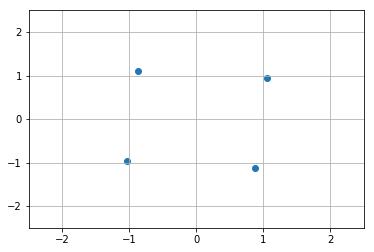

In [18]:
# ploting constellation diagram
import matplotlib.pyplot as plt
scatter_plot = scatter_plot.reshape(M,2,1)
plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()
plt.show()

In [19]:
def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

In [20]:
# calculating BER
# this is optimized BER function so it can handle large number of N
# previous code has another for loop which was making it slow
EbNodB_range = list(frange(-4,8.5,0.5))
ber = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = N
    noise = noise_std * np.random.randn(nn,n_channel)
    encoded_signal = encoder.predict(test_data) 
    final_signal = encoded_signal + noise
    pred_final_signal =  decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ber[n] = no_errors / nn 
    print ('SNR:',EbNodB_range[n],'BER:',ber[n])
    # use below line for generating matlab like matrix which can be copy and paste for plotting ber graph in matlab
    #print(ber[n], " ",end='')

SNR: -4 BER: 0.34026
SNR: -3.5 BER: 0.3167
SNR: -3.0 BER: 0.29314
SNR: -2.5 BER: 0.2685
SNR: -2.0 BER: 0.24492
SNR: -1.5 BER: 0.22562
SNR: -1.0 BER: 0.1997
SNR: -0.5 BER: 0.17272
SNR: 0.0 BER: 0.153
SNR: 0.5 BER: 0.13234
SNR: 1.0 BER: 0.11028
SNR: 1.5 BER: 0.09064
SNR: 2.0 BER: 0.07504
SNR: 2.5 BER: 0.0587
SNR: 3.0 BER: 0.0465
SNR: 3.5 BER: 0.0357
SNR: 4.0 BER: 0.02532
SNR: 4.5 BER: 0.01896
SNR: 5.0 BER: 0.01142
SNR: 5.5 BER: 0.00818
SNR: 6.0 BER: 0.00516
SNR: 6.5 BER: 0.0031
SNR: 7.0 BER: 0.00138
SNR: 7.5 BER: 0.001
SNR: 8.0 BER: 0.00034


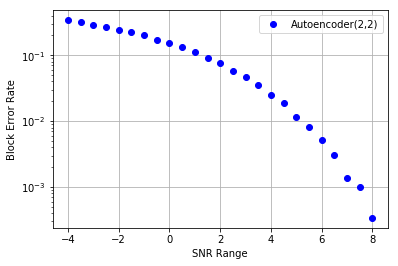

In [21]:
# ploting ber curve
import matplotlib.pyplot as plt
from scipy import interpolate
plt.plot(EbNodB_range, ber, 'bo',label='Autoencoder(2,2)')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='upper right',ncol = 1)

In [22]:
# for saving figure remove below comment
#plt.savefig('AutoEncoder_2_2_constrained_BER_matplotlib')
plt.show()